# House Price Prediction using ML Mdoel Selection and Evaluation

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

# import struct
# print(struct.calcsize("P") * 8) 

## Load Data

In [8]:
target = pd.read_csv('target.csv')
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
train.shape,target.shape, test.shape

((1453, 321), (1453, 1), (1459, 321))

## Setup Cross Validation and Define Error Metrics

In [5]:
# setup cross validation folds
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [10]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train):
    rmse = np.sqrt(-cross_val_score(model, X, target, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Setup Model Pipelines, Train and Fit Models

### Setup Level 1 Models

Try using machine learning models (both regression and tree-based models) to predict SalePrice first. Then consider stacking and blending based on RMSEs.

In [164]:
# regularized regression 
# a range of values that the model considers each time in runs a CV
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
lasso_alphas = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
net_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
net_l1ratio = [0.1,0.3,0.5,0.8, 0.85, 0.9, 0.95, 0.99, 1]
"""
naming pipelines in order to refer to the model itself and get their coefficients later

important: add RobustScaler to make regressions more robust to the outliers, otherwise the result
will be totally different and even not related to totalSF or OverallQuality, without any obvious pattern
"""

# ridge regressor
ridge = Pipeline([('rs',RobustScaler()), ('ridgecv',RidgeCV(alphas=ridge_alphas, cv=kf))])
# lasso regressor
lasso = Pipeline([('rs',RobustScaler()), ('lassocv',LassoCV(max_iter=1e7, 
                    alphas=lasso_alphas,random_state=42, cv=kf))])
# elastic net regressor
elasticnet = Pipeline([('rs',RobustScaler()), ('encv',ElasticNetCV(max_iter=1e7, 
                         alphas=net_alphas, cv=kf, l1_ratio=net_l1ratio))])

# light gradient boosting regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)


# # support vector regressor
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# gradient boosting regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# random forest regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)


### Train Level 1 Models

In [17]:
scores = {}
# lightbgm
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())
# xgboost
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())
# ridge
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())
# lasso
score = cv_rmse(lasso)
print("lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lasso'] = (score.mean(), score.std())
#elasticnet
score = cv_rmse(elasticnet)
print("elasticnet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['elasticnet'] = (score.mean(), score.std())
# random forest
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())
# gradient boosting
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

lightgbm: 0.1128 (0.0233)
[20:51:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_ob

### Fit Level 1 Models

In [19]:
print('Fit level 1 models')
lgb_model_fit = lightgbm.fit(train,target)
xgb_model_fit = xgboost.fit(train,target)
ridge_model_fit = ridge.fit(train,target)
lasso_model_fit = lasso.fit(train,target)
net_model_fit = elasticnet.fit(train,target)
rf_model_fit = rf.fit(train,target)
gbr_model_fit = gbr.fit(train,target)

Fit level 1 models
[21:36:34] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


### Setup Level 2 Models

Try using advanced modeling methods to get lower RMSE.

In [28]:
# stack up all the models above, optimized using xgboost
stack = StackingCVRegressor(regressors=(xgboost, lightgbm, ridge, lasso, elasticnet, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [30]:
# get score of the stacked model
stack_model_fit = stack.fit(train, target)
stack_predict=stack_model_fit.predict(np.array(train))
stack_score = rmsle(target, stack_predict)
scores['stack'] = (stack_score, 0)
print('RMSLE score on train data:')
print(stack_score)

RMSLE score on train data:
0.08386032787773566


In [116]:
# blend models based on a weighted average to make model more robust to overfitting
def blended_predictions(train):
    return ((0.1 * lgb_model_fit.predict(train)) + \
            (0.05 * xgb_model_fit.predict(train)) + \
            ((0.1 * ridge_model_fit.predict(train))).ravel() + \
            # here, ridge regression fit result is a 2-D array rather than a 1-D array as other predict results
            # need further inspection into why this happened
            (0.15 * lasso_model_fit.predict(train)) + \
            (0.1 * net_model_fit.predict(train)) + \
            (0.15 * gbr_model_fit.predict(train)) + \
            (0.05 * rf_model_fit.predict(train)) + \
            (0.3 * stack_model_fit.predict(np.array(train))))

In [117]:
# get score of the blended model
blended_score = rmsle(target, blended_predictions(train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08039363523225168


## Identify Best Performed Model

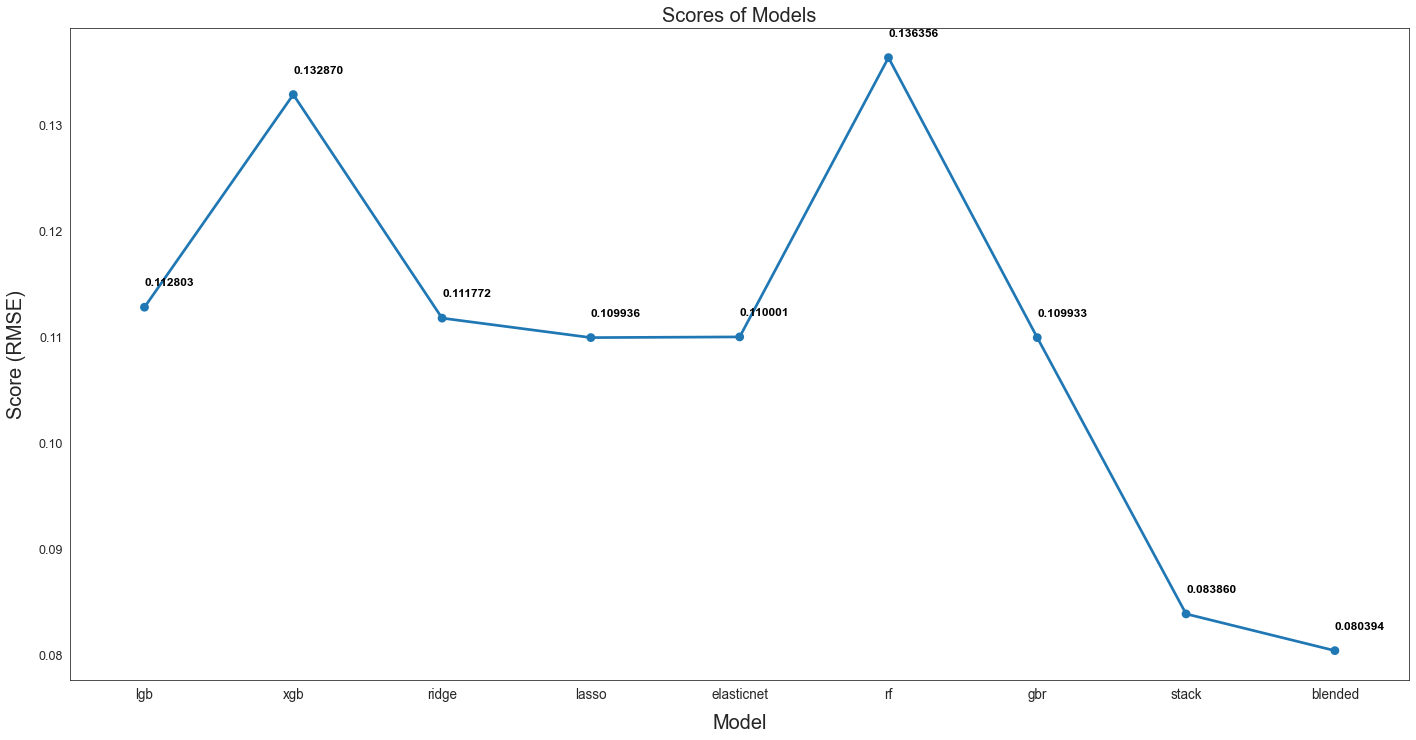

In [126]:
# plot RMSEs
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

Overall, the blended model performed best with the lowest RMSE score. However, either blended model or stacked model is easy to interpret and find out feature importance. Thus, for Kaggle Competition result submission, I used the predicted result from the blended model, and for feature importance interpretations, I used lasso regression, elastic net, and gradient boosting as shown in the last part of this notebook.

## Save the Result from the Best Model for Submission

In [118]:
submission = pd.read_csv("sample_submission.csv")
submission.shape

(1459, 2)

In [119]:
# append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(test)))

In [121]:
submission.to_csv("my_submission.csv", index=False)
print('Save submission', datetime.now(),)

Save submission 2020-06-28 01:32:03.600606


## Feature Importance

Besides the stack model and the blend model, the best performed models which are rather interpretable are the lasso regression, elastic net regression, and the gradient boosting regressor, so below I tried to find which features associate more with the SalePrice according to feature importance.

### Lasso Regression Feature Importance

Text(0.5, 1.0, 'Coefficients with magnitude greater than 0.03')

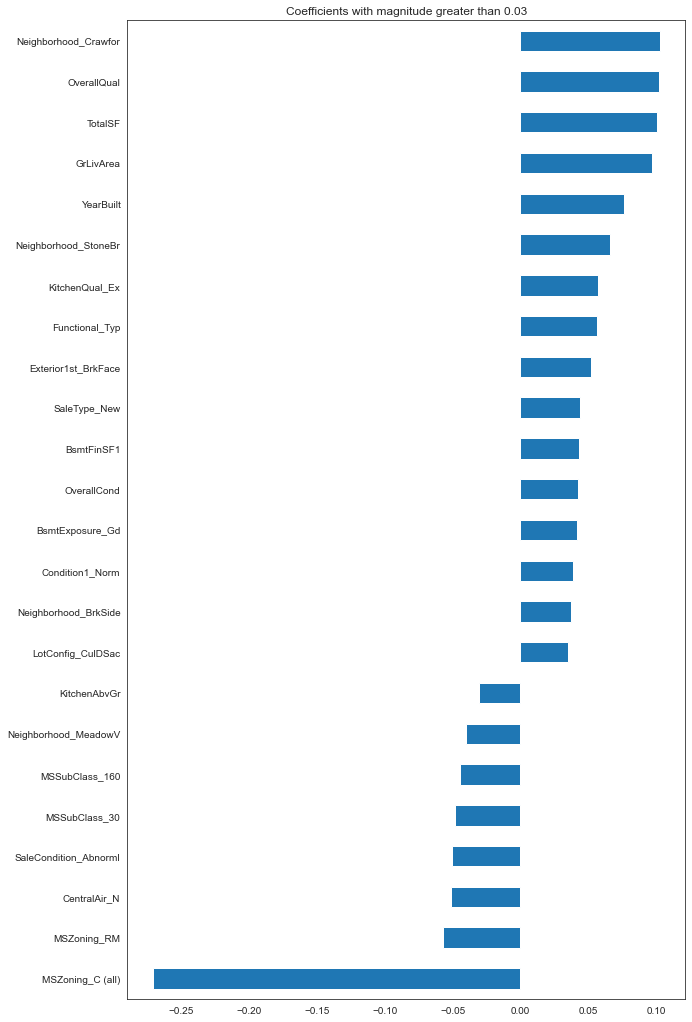

In [166]:
# lasso feature importance by visualizing the coefficients
# lasso.fit(train,target)
lasso_best_model = lasso.named_steps['lassocv']
coefs = pd.Series(lasso_best_model.coef_,index=train.columns)
plt.figure(figsize=(10,18))
coefs[coefs.abs()>0.03].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.03')

### Elastic Net Regression Feature Importance

Text(0.5, 1.0, 'Coefficients with magnitude greater than 0.03')

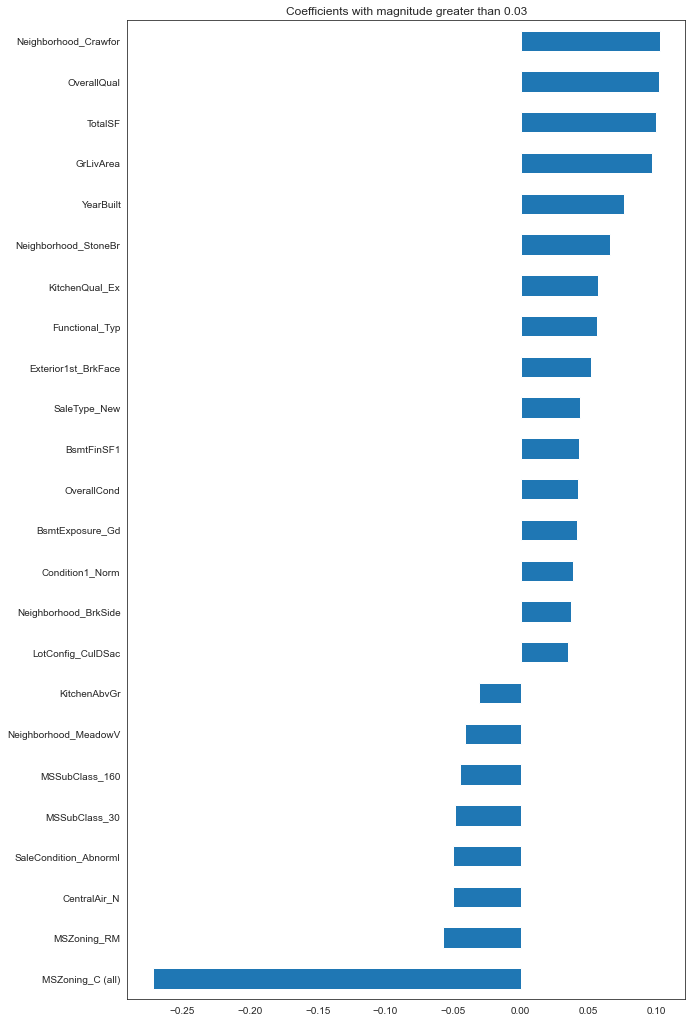

In [167]:
# elastic net feature importance by visualizing the coefficients
# elasticnet.fit(train,target)
net_best_model = elasticnet.named_steps['encv']
coefs_2 = pd.Series(net_best_model.coef_,index=train.columns)
plt.figure(figsize=(10,18))
coefs_2[coefs_2.abs()>0.03].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.03')

### Gradient Boost Regressor Feature Importance

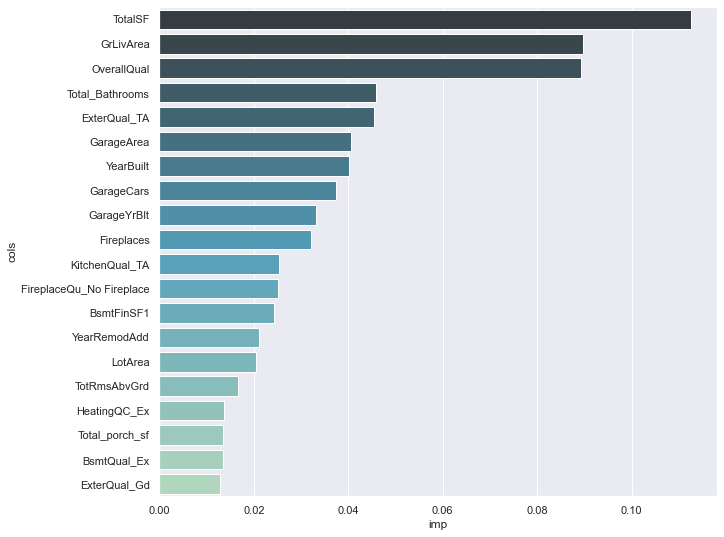

In [169]:
#  gradient boosting feature importance by visualizing the model.feature_importances_
gbr.fit(train,target)
fi = pd.DataFrame({'cols':train.columns, 'imp':gbr.feature_importances_}
                       ).sort_values('imp', ascending=False)[:20]

sns.set(rc={'figure.figsize':(10,9)})
sns.barplot(data=fi, y='cols', x='imp', palette="GnBu_d");